#### Importing libraries

In [28]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import tensorflow as tf
from tensorflow import keras 
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import time 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulsharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Importing the dataset

In [29]:
train_dataset = pd.read_csv('/Users/rahulsharma/Desktop/NeosisTech/reviews_csv/train.csv')
print(train_dataset.head())

                                              review sentiment
0  Great little thriller. I was expecting some ty...  positive
1  Nothing could have saved this movie, not even ...  negative
2  This was a good movie. It wasn't your typical ...  positive
3  From the pen of Richard Condon (The Manchurian...  negative
4  I suppose that today this film has relevance b...  negative


#### Cleaning the dataset

In [30]:
train_dataset['review'] = train_dataset['review'].replace({'<.*?>': ''}, regex=True)
train_dataset['review'] = train_dataset['review'].replace({'[^A-Za-z]': ' '}, regex=True)


#### Stopwords + Tokenization

In [31]:
start_time = time.time()

corpus = [
    [word.lower() for word in word_tokenize(text)]
    for text in train_dataset['review']
]

# Get English stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from each list of tokenized words in the corpus
processed_corpus = [
    [word for word in words if word not in stop_words]
    for words in corpus
]

end_time = time.time()
time_taken = end_time-start_time
print(f"Time taken to compile: {time_taken:.2f} seconds")

Time taken to compile: 10.56 seconds


#### Label Encoding

In [32]:
label_encoder = LabelEncoder()
train_dataset['sentiment'] = label_encoder.fit_transform(train_dataset['sentiment'])


#### Splitting the dataset into test and train

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
    processed_corpus, train_dataset['sentiment'], test_size=0.2, random_state=42
)

#### Tokenization + Pad Sequence

In [34]:
num_words = 10000  # you can adjust this based on your dataset
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=128, truncating='post', padding='post')

x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=128, truncating='post', padding='post')

#### LSTM Architecture

In [35]:
EMBED_DIM = 50
LSTM_OUT = 128

model = Sequential()
model.add(Embedding(num_words, EMBED_DIM, input_length=128))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(LSTM_OUT, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))  # Changed to 'sigmoid' for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 50)           500000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 128, 50)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 591777 (2.26 MB)
Trainable params: 591777 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### Fitting the model

In [36]:
start = time.time()
model.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1)
end = time.time()
total = end-start
print(f"Time taken to compile: {total:.2f} seconds")

Epoch 1/5
157/157 [==============================] - 34s 195ms/step - loss: 0.6935 - accuracy: 0.5196
Epoch 2/5
157/157 [==============================] - 33s 208ms/step - loss: 0.4759 - accuracy: 0.7829
Epoch 3/5
157/157 [==============================] - 30s 189ms/step - loss: 0.2837 - accuracy: 0.8973
Epoch 4/5
157/157 [==============================] - 32s 205ms/step - loss: 0.2597 - accuracy: 0.9108
Epoch 5/5
157/157 [==============================] - 31s 199ms/step - loss: 0.1947 - accuracy: 0.9345
Time taken to compile: 159.44 seconds


## Evaluation on train dataset

#### Model evaluation on the train set 

In [37]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Training Accuracy:', train_accuracy)
print("Train loss: ", train_loss)

625/625 [==============================] - 13s 21ms/step - loss: 0.1275 - accuracy: 0.9622
Training Accuracy: 0.9622499942779541
Train loss:  0.12754063308238983


#### Model evaluation on the test set 

In [38]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

157/157 [==============================] - 4s 24ms/step - loss: 0.3389 - accuracy: 0.8776
Test Loss: 0.33891409635543823
Test Accuracy: 0.8776000142097473


#### Calculate total predictions, correct predictions, and incorrect predictions


In [39]:
# Predictions on the test set
y_pred = (model.predict(x_test) > 0.5).astype(int).flatten()

# Calculate total predictions, correct predictions, and incorrect predictions
total_predictions = len(y_test)
correct_predictions = np.sum(y_test == y_pred)
incorrect_predictions = total_predictions - correct_predictions

print('Total Predictions:', total_predictions)
print('Correct Predictions:', correct_predictions)
print('Incorrect Predictions:', incorrect_predictions)

157/157 [==============================] - 4s 22ms/step
Total Predictions: 5000
Correct Predictions: 4388
Incorrect Predictions: 612


#### Predicting accuracy of a single review

In [40]:
# Input your review here
positive_review = "This movie is an absolute masterpiece! The acting is superb, the storyline is captivating, and the cinematography is breathtaking. I couldn't help but be immersed in the characters and their journey. A must-watch for any movie lover!"

# Preprocess the review
review_sequence = [positive_review]
review_sequence = [review.lower() for review in review_sequence]
review_sequence = tokenizer.texts_to_sequences(review_sequence)
review_sequence_padded = pad_sequences(review_sequence, maxlen=128, truncating='post', padding='post')

# Predict sentiment
predicted_sentiment = model.predict(review_sequence_padded)[0]

# Interpret the prediction
if predicted_sentiment >= 0.5:
    sentiment_label = 'Positive'
else:
    sentiment_label = 'Negative'

print(f"Predicted Sentiment: {sentiment_label}")
print(f"Predicted Probability: {predicted_sentiment[0]}")
print(f"Test Accuracy: {accuracy}")


1/1 [==============================] - 0s 32ms/step
Predicted Sentiment: Positive
Predicted Probability: 0.9788920879364014
Test Accuracy: 0.8776000142097473


## Evaluation on test dataset

In [41]:
test_dataset = pd.read_csv('/Users/rahulsharma/Desktop/NeosisTech/reviews_csv/test.csv')

In [42]:
# Assuming 'test_dataset' is the DataFrame from the new test set
test_dataset['review'] = test_dataset['review'].replace({'<.*?>': ''}, regex=True)
test_dataset['review'] = test_dataset['review'].replace({'[^A-Za-z]': ' '}, regex=True)

# Tokenize and convert to lowercase for each text in the 'review' column of the test set
corpus_test = [
    [word.lower() for word in word_tokenize(text)]
    for text in test_dataset['review']
]

# Get English stop words
stop_words = set(stopwords.words('english'))

# Remove stop words from each list of tokenized words in the test set corpus
processed_corpus_test = [
    [word for word in words if word not in stop_words]
    for words in corpus_test
]

# Tokenize and pad sequences for the test set
x_test_new = tokenizer.texts_to_sequences(processed_corpus_test)
x_test_new = pad_sequences(x_test_new, maxlen=128, truncating='post', padding='post')

# Encode labels for the test set
y_test_new = label_encoder.transform(test_dataset['sentiment'])

# Model evaluation on the new test set
loss, accuracy = model.evaluate(x_test_new, y_test_new, verbose=1)
print(' Test Dataset Loss:', loss)
print(' Test Dataset Accuracy:', accuracy)


782/782 [==============================] - 17s 21ms/step - loss: 0.4118 - accuracy: 0.8534
 Test Dataset Loss: 0.411791056394577
 Test Dataset Accuracy: 0.8533807396888733


#### Calculate total predictions, correct predictions, and incorrect predictions


In [43]:
# Predictions on the test set
y_pred_new = (model.predict(x_test_new) > 0.5).astype(int).flatten()

# Calculate total predictions, correct predictions, and incorrect predictions
total_predictions = len(y_test_new)
correct_predictions = np.sum(y_test_new == y_pred_new)
incorrect_predictions = total_predictions - correct_predictions

print('Total Predictions:', total_predictions)
print('Correct Predictions:', correct_predictions)
print('Incorrect Predictions:', incorrect_predictions)

782/782 [==============================] - 17s 21ms/step
Total Predictions: 25000
Correct Predictions: 21334
Incorrect Predictions: 3666


#### Confusion Matrix

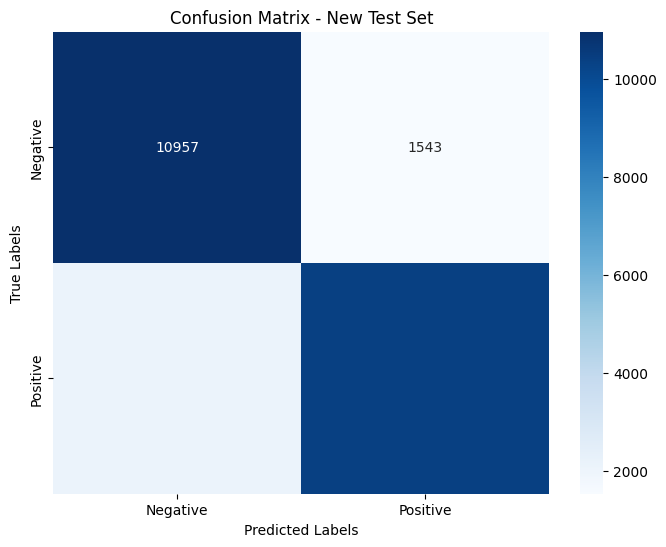

Classification Report (New Test Set):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.87      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_test_new, y_pred_new)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - New Test Set')
plt.show()

# Classification report
print('Classification Report (New Test Set):\n', classification_report(y_test_new, y_pred_new))
